In [197]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

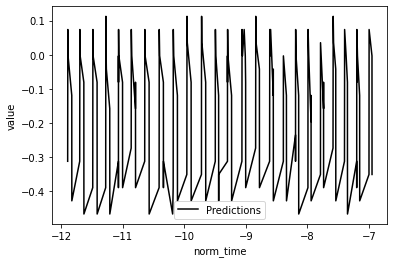

In [198]:
# Read dataset from file
raw_dataset = pd.read_csv("./data_grouped/1161114002_122.csv")
raw_dataset = raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float', 'norm_value':'float'})
dataset = raw_dataset.copy()
dataset = dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
dataset = dataset.sort_values(by=['norm_time'])
dataset = dataset[0:300]
dataset.shape

plt.plot(dataset['norm_time'], dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('norm_time')
plt.ylabel('value')
plt.legend()
plt.show()

In [199]:
# Split data into training and testing
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [200]:
# Split input features and lables
train_features = train_dataset.copy().sort_values(by=['norm_time'])
test_features = test_dataset.copy().sort_values(by=['norm_time'])
train_labels = train_features.pop('norm_value')
test_labels = test_features.pop('norm_value')

In [201]:
# Normalize single column in dataset

input_col = np.array(train_features['norm_time'])
input_col_normalizer = preprocessing.Normalization()
input_col_normalizer.adapt(input_col)
# input_col = input_col.reshape(input_col.shape[0],1,1)

out_col = np.array(train_labels)
# out_col = out_col.reshape(out_col.shape[0],1)

test_col = np.array(test_features['norm_time'])
# test_col = test_col.reshape(test_col.shape[0],1,1)

lable_col = np.array(test_labels)
# lable_col = lable_col.reshape(lable_col.shape[0],1)

In [202]:
# Model Init fucntion
def build_and_compile_model(norm):
#   model = keras.Sequential()
#   model.add(layers.LSTM(32,return_sequences=True, input_shape=(1, 1)))
#   model.add(layers.LSTM(32,return_sequences=True))
#   model.add(layers.TimeDistributed(layers.Dense(1)))
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
  # Setup optimizer, learning rate, and loss function
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model
DNN_single_model = build_and_compile_model(input_col_normalizer)

In [203]:
# Save Train loss each epochs for later analysis
history = DNN_single_model.fit(
    input_col, out_col,
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)
print(DNN_single_model.summary())
print(history)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_13 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________
None


In [195]:
# Evaluate model in testing dataset
test_results = {}
test_results['DNN_single_var_model'] = DNN_single_model.evaluate(
    test_col,
    lable_col, verbose=0)
print (pd.DataFrame(test_results, index=['Mean absolute error [norm_value]']).T)

                      Mean absolute error [norm_value]
DNN_single_var_model                          0.548087


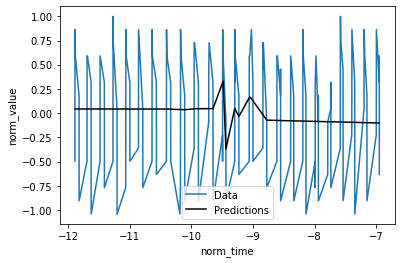

In [196]:
# Ploting result
x = np.array(dataset['norm_time'])
x = x.reshape(x.shape[0],1,1)
y = DNN_single_model.predict(x)
def plot_horsepower(x, y):
  plt.plot(train_features['norm_time'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('norm_time')
  plt.ylabel('norm_value')
  plt.legend()
  plt.show()
x = x.reshape(x.shape[0],1)
y = y.reshape(y.shape[0],1)
plot_horsepower(x,y)